<a href="https://colab.research.google.com/github/Varshith6690/Varshith6690/blob/main/Sepsis_Detection_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary libraries
!pip install pandas scikit-learn joblib imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.utils import resample

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Load the dataset
df = pd.read_csv('/content/sepsis.csv')

# Keep only specified columns
columns_to_keep = ['HR', 'O2Sat', 'Temp', 'SBP', 'Resp', 'SepsisLabel']
df = df[columns_to_keep]

# Check missing values in 'Temp' and fill them optimally
imputer = SimpleImputer(strategy='median')
df['Temp'] = imputer.fit_transform(df[['Temp']])

# Drop any remaining missing values
df = df.dropna()

# Separate majority and minority classes
df_majority = df[df.SepsisLabel == 0]
df_minority = df[df.SepsisLabel == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                  replace=True,     # sample with replacement
                                  n_samples=len(df_majority),  # to match majority class
                                  random_state=123)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check the new distribution of SepsisLabel
print("\nSepsisLabel distribution after balancing:\n", df_upsampled.SepsisLabel.value_counts())

# Split features and target variable
X = df_upsampled.drop('SepsisLabel', axis=1)
y = df_upsampled['SepsisLabel']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



SepsisLabel distribution after balancing:
 SepsisLabel
0    37945
1    37945
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up Grid Search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'max_depth': [None, 10],      # Reduced from [None, 10, 20, 30]
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

# Save the best model
joblib.dump(best_rf_model, 'sepsis_rf_model_optimized.pkl')
print("Optimized model saved as 'sepsis_rf_model_optimized.pkl'")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Optimized model saved as 'sepsis_rf_model_optimized.pkl'



Optimized Model Accuracy: 96.03%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      7552
           1       1.00      0.92      0.96      7626

    accuracy                           0.96     15178
   macro avg       0.96      0.96      0.96     15178
weighted avg       0.96      0.96      0.96     15178


Confusion Matrix:
 [[7523   29]
 [ 574 7052]]


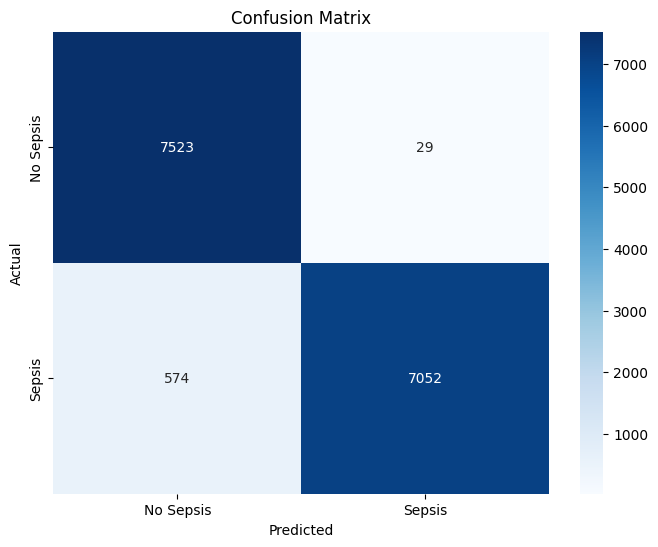

In [7]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOptimized Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load the trained model
model_path = '/content/sepsis_rf_model_optimized.pkl'
model = joblib.load(model_path)

# Define alert thresholds
def get_alert_level(probability):
    if probability <= 0.3:
        return "Green: Normal (Low Risk)"
    elif 0.3 < probability <= 0.7:
        return "Yellow: Moderate Risk"
    else:
        return "Red: High Risk"

# Initialize Flask app
app = Flask(__name__)

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    # Parse incoming JSON data
    data = request.get_json()

    try:
        # Extract features for prediction
        features = np.array([[data["HR"], data["O2Sat"], data["Temp"], data["SBP"], data["Resp"]]])
    except KeyError as e:
        return jsonify({"error": f"Missing field: {str(e)}"}), 400

    # Generate prediction
    probability = model.predict_proba(features)[0, 1]  # Probability for sepsis
    alert_level = get_alert_level(probability)

    return jsonify({
        "sepsis_probability": probability,
        "alert_level": alert_level
    })

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import random
import time
import requests

# Simulate real-time patient data
def generate_real_time_data():
    return {
        "HR": random.randint(60, 120),         # Heart rate
        "O2Sat": random.uniform(85, 100),     # Oxygen saturation
        "Temp": random.uniform(36, 39),       # Temperature
        "SBP": random.randint(90, 140),       # Systolic blood pressure
        "Resp": random.randint(12, 30)        # Respiratory rate
    }

# Send data to the Flask API for prediction
api_url = "http://127.0.0.1:5000/predict"  # Update with your Flask app URL if different
while True:
    patient_data = generate_real_time_data()
    response = requests.post(api_url, json=patient_data)
    print("Real-Time Data Sent:", patient_data)
    print("Response:", response.json())  # Display prediction and alert level
    time.sleep(5)  # Simulate 5-second intervals


In [ ]:
from termcolor import colored

def display_alert(alert_response):
    alert_level = alert_response["alert_level"]

    if "Green" in alert_level:
        print(colored(f"ALERT: {alert_level}", 'green'))
    elif "Yellow" in alert_level:
        print(colored(f"ALERT: {alert_level}", 'yellow'))
    elif "Red" in alert_level:
        print(colored(f"ALERT: {alert_level}", 'red'))

# Example usage
response = {
    "sepsis_probability": 0.85,
    "alert_level": "Red: High Risk"
}
display_alert(response)
